**Imports**

Here we import all libraries we'll use and install `matplotlib` and `numby` modules needed for further work.

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv

In [15]:
X = []
Y = []
with open('data.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in spamreader:
        X.append(int(row[0]))
        Y.append(int(row[1]))

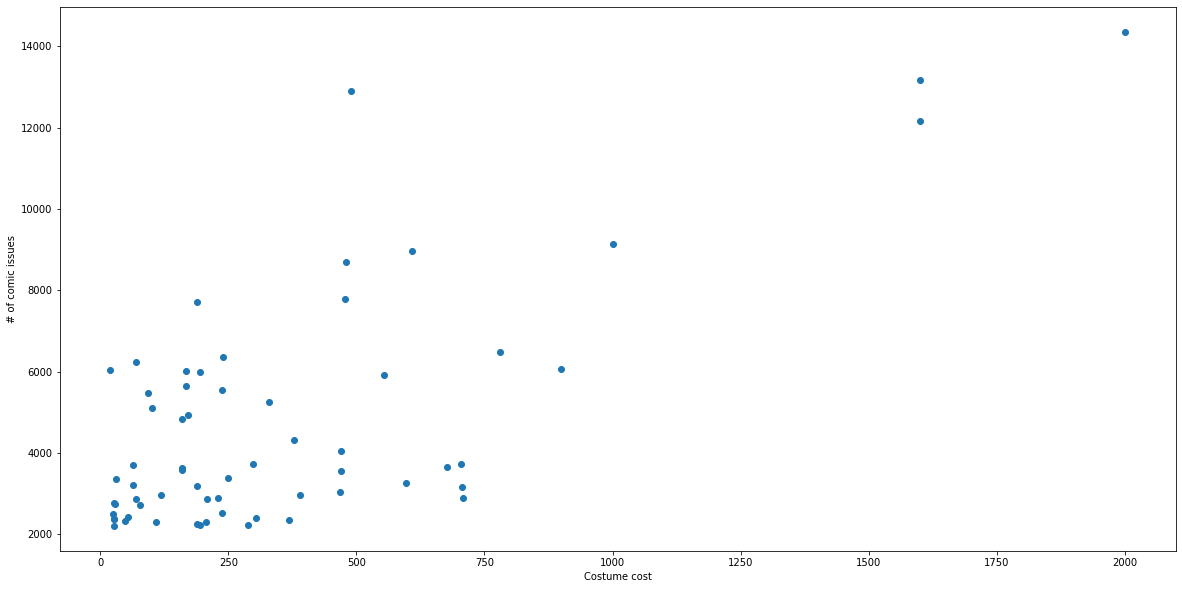

In [16]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.scatter(X,Y,marker="o")
plt.xlabel("Costume cost")
plt.ylabel("# of comic issues")
plt.show()

In [17]:
def generate_binary_phenotype(size: int):
    return [random.randrange(0, 2, 1) for i in range(size)]

def generate_population(population_size: int, phenotype_size: int, generator):
    return [generator(phenotype_size) for i in range(population_size)]

In [18]:
population = generate_population(100, 16, generate_binary_phenotype)

print(f"Population size: {len(population)}")
print(f"First individual: {str(population[0])}")

Population size: 100
First individual: [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]


In [19]:
def decode_individual(individual):
    half = int(len(individual)/2)
    a = int("".join(str(x) for x in individual[0:half]), 2)
    b = int("".join(str(x) for x in individual[half:]), 2)
    return a, b

def fitness_function(individual):
    a, b = decode_individual(individual)
    fitness = 0
    for i in range(len(x)):
        fitness = fitness + abs(Y[i] - (a*X[i]+b))
    return individual, fitness

In [20]:
test_individual = population[0]
test_individual, fitness_value = fitness_function(test_individual)
print(f"First individual: {str(test_individual)} has fitness value: {fitness_value}")

First individual: [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1] has fitness value: 4908901


In [29]:
individual_fitness_pairs = list(map(fitness_function, population))
best = min(individual_fitness_pairs, key=lambda item: item[1])
worst = max(individual_fitness_pairs, key=lambda item: item[1])


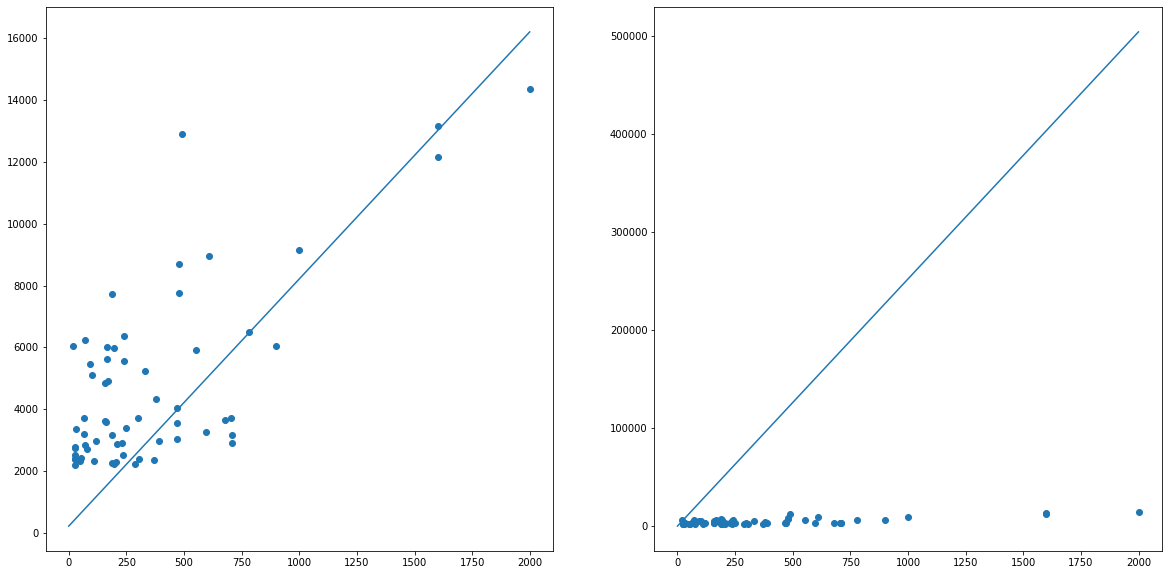

In [33]:
a_best, b_best = decode_individual(best[0])
a_worst, b_worst = decode_individual(worst[0])

plt.rcParams['figure.figsize'] = [20, 10]

figure, axis = plt.subplots(ncols=2)

x_best = np.arange(0.0, 2000.0, 1.0)
y_best = np.add(np.multiply(x_best,a_best), b_best)

x_worst = np.arange(0.0, 2000.0, 1.0)
y_worst = np.add(np.multiply(x_worst,a_worst), b_worst)

axis[0].scatter(x,y,marker="o")
axis[1].scatter(x,y,marker="o")
axis[0].plot(x_best, y_best)
axis[1].plot(x_worst, y_worst)

plt.show()

In [42]:
def mutation(individual, initial_mutation_rate):
    mutation_rate = 1/len(individual) if initial_mutation_rate < 0 else initial_mutation_rate
    new_phenotype = []
    for value in individual:
        new_phenotype.append( abs(value - 1) if random.random() < mutation_rate else value)
    return new_phenotype

print ("Original phenotype: " +  str(worst[0]))
mutant = mutation(worst[0], 0.5)
print ("Mutated phenotype : " +  str(mutant))

Original phenotype: [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Mutated phenotype : [1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1]


In [46]:
def recombination(individual_1, individual_2):
    crossover_point = random.randrange(1, len(individual_1), 1)
    child_1 = individual_1[:crossover_point] + individual_2[crossover_point:]
    child_2 = individual_2[:crossover_point] + individual_1[crossover_point:]
    return child_1, child_2

test_1 = [1, 1, 1, 1, 1, 1, 1, 1]
test_2 = [0, 0, 0, 0, 0, 0, 0, 0]
child_1, child_2 = recombination(test_1, test_2)
print(f"Children: {str(child_1)} & {str(child_2)}")

Children: [1, 1, 1, 1, 1, 1, 0, 0] & [0, 0, 0, 0, 0, 0, 1, 1]


In [74]:
test = [('a', 10), ('b', 17), ('c', 11)]
def monte_carlo_selection(individual_fitness_pairs):
    individual_fitness_pairs.sort(key=lambda x : x[1])
    print(str(test))
    temp = list(map(lambda x : (x[0], x[1] - test[0][1] + 1), test))
    print(str(temp))
    rand = random.randrange(0, temp[len(temp)-1][1] + 1, 1)
    print(rand)
    xxx = list(filter(lambda x: rand <= x[1], temp))[0]
    print(xxx)
monte_carlo_selection(test)

[('a', 10), ('c', 11), ('b', 17)]
[('a', 1), ('c', 2), ('b', 8)]
8
('b', 8)
